Otimização de investimentos é o processo de selecionar a melhor composição de carteira de ativos possível. Não existe carteira perfeita, mas a elaboração de estratégias que maximizem retornos a um dado risco é a prioridade dos investidores modernos. Embora essa ideia pareça simples, apenas na metade do século passado Harry Markowitz desenvolveu um algoritmo — A Fronteira Eficiente — que permite a otimização de investimentos.

O maior pressuposto desse algoritmo é que investidores são avessos a risco. Então, dada uma carteira com um certo nível de retorno esperado, a combinação dos ativos com o menor risco possível será a escolhida pelo investidor. Sob essa premissa, investidores só realizarão operações financeiras de alto risco se puderem esperar altíssimos ganhos.

### A maldição da fronteira eficiente
Algoritmos de otimização como Markowitz são muito sensíveis a pequenas variações nas entradas do modelo, e esses pequenos erros podem resultar em grandes diferenças nas alocações de uma carteira ideal.

Um objeto fundamental para o encontro da fronteira eficiente é a matriz de covariâncias. Com ela é possível analisar as correlações entre todos os ativos e estimar o risco da carteira.

Matrizes de covariâncias são muito complexas para serem analisadas pois levam em conta toda a composição da carteira. Isso significa que erros na entrada do modelo acabam afetando o portfólio como um todo.Uma matriz de covariâncias também pode ser visualizada como um grafo totalmente conectado.

Para reduzir a complexidade do grafo o ideal é eliminar conexões entre ativos pouco correlacionados e focar apenas nas relações relevantes. Para isso pode-se utilizar uma estrutura topológica conhecida como árvore. Tal estrutura além de reduzir a interferência de erros de estimativa, melhora significativamente a interpretação do grafo.

## Hierarchical risk parity
O Hierarchical Risk Parity (HRP) é um algoritmo de otimização de portfólios desenvolvido por Marcos Lopez de Prado. Esse otimizador combina teoria de grafos e machine learning para construir uma carteira diversificada com soluções estáveis.
O HRP pode ser dividido em 3 grandes passos:
1. **Hierarchical Tree Clustering**: Processo de agrupamento de ativos semelhantes utilizando inteligência artificial.
2. **Matrix Seriation**: Reorganização de linhas e colunas da matriz de covariança.
3. **Recursive Bisection**: Atribuição de pesos dos ativos.

### Hierarchical Tree Clustering
Nesta etapa, iremos aplicar uma técnica de aprendizado não supervisionado que é a clusterização hierárquica. Esse tipo de algoritmo visa construir agrupamentos (clusters) segundo um métrica de semelhança entre os dados.
Para isso iremos realizar a aquisição dos preços históricos, para montar uma carteira para ser otimizada. 

A clusterização hierárquica será realizada sobre os retornos históricos do ativos da carteira. Para efetuar essa operação temos dois principais hiperparâmetros: método e métrica.

**Método**: Algoritmo utilizado para a clusterização, iremos utilizar ‘ward’ que computa os agrupamentos a partir de suas variâncias.

**Métrica**: Tipo de medida que avalia a semelhança entre os dados, iremos utilizar a distância euclidiana.

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr

In [2]:
tickers = ['SELIC-R.BK','BBD', 'ITUB', 'HGLG11.SA', 'KNRI11.SA', 'AZUL', 'GOL']

df = pd.DataFrame()

for t in tickers:
    df[t] = pdr.DataReader(t, data_source='yahoo', start='01-01-2019', end = '31-12-2020')['Adj Close']

df.tail()

,SELIC-R.BK,BBD,ITUB,HGLG11.SA,KNRI11.SA,AZUL,GOL
Date,,,,,,,
2020-12-24,1.573042,5.232188,6.099965,NaN,NaN,21.320000,9.39
2020-12-25,1.573042,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,1.573042,5.202793,6.040838,175.000000,162.520004,21.570000,9.28
2020-12-29,1.573042,5.244591,6.070402,178.589996,164.410004,21.760000,9.42
2020-12-30,1.573042,5.244591,6.040838,181.000000,162.320007,22.780001,9.65


In [3]:
returns = df.pct_change()
returns = returns.dropna()
returns.head()

,SELIC-R.BK,BBD,ITUB,HGLG11.SA,KNRI11.SA,AZUL,GOL
Date,,,,,,,
2019-01-03,0.0,0.012730,0.013388,0.000355,0.010829,0.002090,-0.002234
2019-01-04,0.0,0.013035,0.013212,-0.004966,0.000798,0.007647,0.008209
2019-01-07,0.0,-0.002757,-0.009027,0.008913,-0.006183,-0.032770,-0.050333
2019-01-08,0.0,0.016590,0.018219,0.003534,0.001472,-0.008916,0.016368
2019-01-09,0.0,0.026291,0.020875,0.009437,-0.005879,0.014754,-0.013804


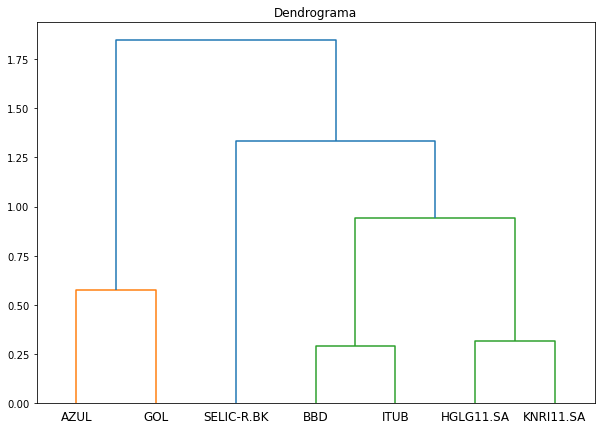

In [4]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 7))  
plt.title("Dendrograma")

clusters = shc.linkage(returns.T, method='ward', metric='euclidean')

dendograma = shc.dendrogram(clusters, labels=returns.columns)

Apenas a partir dos retornos históricos, o algoritmo conseguiu identificar e segmentar diversos setores do mercado:

* Renda Fixa: Selic
* Aviação: Azul e Gol
* Setor bancário: Bradesco e Itaú
* Fundos imobiliários: HGLG11 e KNRI11

### Matrix Seriation
O objetivo dessa etapa é preparar a matriz de covariâncias para a atribuição de pesos. Utilizando os clusters gerados na etapa anterior, podemos recombinar as linhas e colunas da matriz de covariância, a fim de que ativos semelhantes estejam posicionados proximos.

In [5]:
import seaborn as sns

def matrix_seriation(retornos: pd.DataFrame):

    matriz_covarianca = retornos.cov()

    dendograma = sns.clustermap(matriz_covarianca, method='ward', metric='euclidean')

    colunas_seriation = dendograma.dendrogram_col.reordered_ind
    colunas_seriation = retornos.columns[colunas_seriation]

    return (matriz_covarianca, colunas_seriation)

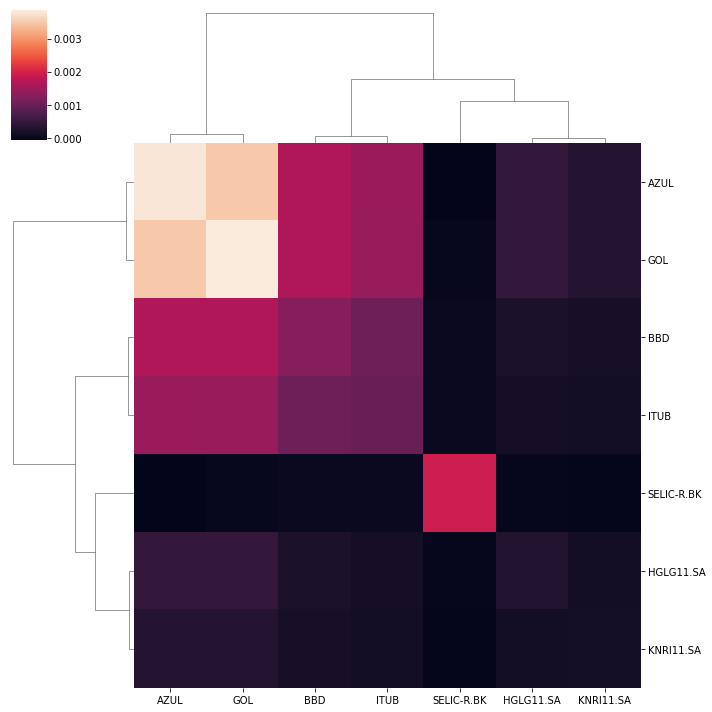

In [6]:
(matriz_cov, colunas_seriation) = matrix_seriation(returns)

### Recursive Bisection
Essa é a última e mais importante etapa do algoritmo, momento no qual os pesos serão atribuídos. A matriz de covariâncias gerada na etapa de Seriation é fundamental, pois ela será utilizada para realizar a iteração nos nós do grafo do dendograma. O algoritmo pode ser representado pelos seguintes passos:

1) Inicialização dos pesos

Todos os ativos recebem peso igual a 1.

$$\begin{equation}
W_i = 1, i = 1,2,...,N
\end{equation}$$

2) Iteração entre os nós da árvore
Com a matriz de covariâncias, percorre-se a árvore selecionando os sub-clusters e sub-matrizes respectivos. O objetivo é realizar a diversificação de pesos entre ativos semelhantes.
Olhando o dendograma do passo 1 pode-se exemplificar um hipotético par de carteiras:
* Carteira 1: Fundos de investimentos. Que são compostos por 2 ativos, ou seja, tem uma matriz de covariâncias V1, com dimensão 2 x 2.
* Carteira 2: Setor bancário. Que também é composta por 2 ativos, resultando em uma matriz de covariâncias V2.

3) Atribuição de pesos pares

Com o objetivo de calcular o risco de cada cluster, iremos atribuir pesos temporários para os ativos do cluster. Dado que cada cluster tem uma matriz de covariâncias (Vi), podemos calcular os pesos da seguinte forma:

$$\begin{equation}
\vec w_i = \frac{diagonal\left[V^{-1}\right]}{soma\left(diagonal\left[V^{-1}\right]\right)}
\end{equation}$$

4) Determinação das volatilidades

A partir da fórmula clássica de volatilidade de um portfólio:

$$\begin{equation}
\sigma_i = \vec w_{i}^{T}V_i\vec w_i
\end{equation}$$

5) Aplicação do fator de peso absoluto

O fator de alocação funciona como uma fator de escala entre a sub-carteira e a carteira completa.

$$\begin{equation}
\alpha_1 = 1-\frac{\sigma_1}{\sigma_1 + \sigma_2} \quad \alpha_2 = \frac{\sigma_1}{\sigma_1 + \sigma_2}
\end{equation}$$

O fatores de alocação tem um valor entre 0 e 1.

O ativos presentes nas sub-carteiras, que foram inicializados com 1, terão seus valores atualizados pelos fatores de alocação.

$$\begin{equation}
W\left[1\right] = \alpha_1W\left[1\right]
\end{equation}$$
$$\begin{equation}
W\left[2\right] = \alpha_2W\left[2\right]
\end{equation}$$

In [7]:
def calcula_pesos_hrp(matriz_cov, colunas_seriation):
    # Inicialização de pesos
    pesos = pd.Series(1, index=colunas_seriation)
    paridades = [colunas_seriation]

    while len(paridades) > 0:
        # Instanciação de clusters
        paridades = [cluster[inicio:fim] 
                     for cluster in paridades
                      for inicio, fim in ((0, len(cluster) // 2),(len(cluster) // 2, len(cluster)))
                        if len(cluster) > 1]

        # Iteração entre paridades
        for subcluster in range(0, len(paridades), 2):
            
            cluster_esquerdo = paridades[subcluster]
            cluster_direito = paridades[subcluster + 1]
            
            matriz_cov_esquerda = matriz_cov[cluster_esquerdo].loc[cluster_esquerdo]
            inversa_diagonal = 1 / np.diag(matriz_cov_esquerda.values)
            pesos_cluster_esquerdo = inversa_diagonal / np.sum(inversa_diagonal)
            vol_cluster_esquerdo = np.dot(pesos_cluster_esquerdo, np.dot(matriz_cov_esquerda, pesos_cluster_esquerdo))

            matriz_cov_direita = matriz_cov[cluster_direito].loc[cluster_direito]
            inversa_diagonal = 1 / np.diag(matriz_cov_direita.values)
            pesos_cluster_direito = inversa_diagonal  / np.sum(inversa_diagonal)
            vol_cluster_direito = np.dot(pesos_cluster_direito, np.dot(matriz_cov_direita, pesos_cluster_direito))

            fator_alocacao = 1 - vol_cluster_esquerdo / (vol_cluster_esquerdo + vol_cluster_direito)

            pesos[cluster_esquerdo] *= fator_alocacao
            pesos[cluster_direito] *= 1 - fator_alocacao
            
    return pesos

In [8]:
calcula_pesos_hrp(matriz_cov, colunas_seriation) * 100

AZUL           2.318152
GOL            1.392947
BBD            4.214601
ITUB          11.883270
SELIC-R.BK     6.170521
HGLG11.SA     24.677308
KNRI11.SA     49.343200
dtype: float64

Esse é o resultado da otimização da carteira. Os valores estão em porcentagem.

### Backtesting da otimização
E na prática? Como essa estratégia performaria no passado?
Essas são as perguntas que queremos responder com o backtesting. Vale ressaltar que rentabilidade passada, não é garantia de rentabilidade futura. Porém ao simular uma estratégia de investimento, podemos obter boas informações de como a estratégia performaria em diversos cenários. Além de analisar a performance, o backtesting é importante para comparação entre diferentes estratégias.

Em nosso backtesting, iremos comparar 3 otimizadores de investimento:
1. **Equal Weight**: Alocação de carteira que atribui peso igual para todos os ativos.
2. **Markowitz**: A Fronteira eficiente, algoritmo clássico de otimização.
3. **HRP: Hierarchical risk parity**: otimizador que utiliza machine learning e teoria de grafos.

In [19]:
# Equal Weight
def compute_unif_pesos(cov):
    
    return [1 / len(cov) for i in range(len(cov))]

# Markowitz
def compute_MV_pesos(cov):
    inv_covar = np.linalg.inv(cov)
    u = np.ones(len(cov))
    
    return np.dot(inv_covar, u) / np.dot(u, np.dot(inv_covar, u))

In [9]:
def compute_portfolio_volatilidade(pesos, retornos):
    return ((pesos * retornos)
            .sum(axis=1)
            .std() * np.sqrt(252))

In [30]:
cov = returns.cov()

methods = {
    'Equal Weight': compute_unif_weights,
    'Markowitz': compute_MV_weights,
}

for name, method in methods.items():
    pesos = method(cov)
    
    vol = compute_portfolio_volatilidade(
        pesos, returns)
    
    print(name + ':\n' +
          'volatilidade: ' + str(round(vol, 4)) + '\n' +
          '\n\n')
    
pesos_hrp = calcula_pesos_hrp(matriz_cov, colunas_seriation)
vol_hrp = compute_portfolio_volatilidade(pesos_hrp, returns)

print('Hierarchical Risk Parity' + ':\n' +
          'volatilidade: ' + str(round(vol_hrp, 4)) + '\n' +
          '\n\n')

Equal Weight:
volatilidade: 0.4476



Markowitz:
volatilidade: 0.1716



Hierarchical Risk Parity:
volatilidade: 0.2286





O método de pesos iguais apresenta o pior resultado com volatilidade alta, logo com alto risco. Já o método de Markovitz tem o melhor resultado. Nesse caso, não é de se admirar que o método Hierarchical Risk Parity não tenha o melhor desempenho: ele cria uma ordem dos ativos com base em um algoritmo de agrupamento hierárquico cujo resultado é totalmente espúrio, pois não existem clusters aninhados. Nesse caso específico, usar o método de bissecção (algoritmo original de Lopez de Prado) em vez de seguir as divisões do dendrograma (uma ideia alternativa que parece intuitivamente melhor) pode aliviar o problema de encontrar um agrupamento de correlação espúrio, ainda assim o resultado é próximo do método de Markowitz.